## Homework 10
### Jingrong Tian
The following three cells are methods for backtracking, log-barrier and import packages

In [44]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt


In [45]:
def backtrack(x0, dx, f, df0, alpha, beta, verbose=False):
    '''
    Backtracking for general functions
    :param x0: initial point
    :param dx: incremental factor for updating x0
    :param f: objective function
    :param df0: gradient of f at x0
    :param alpha: sloping factor of stopping criterion
    :param beta: aggressiveness parameter for backtracking steps
    :param verbose: if True, return the objective function 
        value at the final x
    '''
    
    # np.dot corresponds to a tensor product
    delta = alpha * np.dot(dx, df0)
    
    t = 1
    f0 = f(x0)
    x = x0 + dx  # t = 1
    fx = f(x)
    
    while (not np.isfinite(fx)) or fx > f0 + delta * t:
        # this is cheaper than exponentiating beta each time
        t = beta * t
        x = x0 + t * dx
        fx = f(x)
        
    if verbose:
        return x, f(x)
    else:
        return x
    

def backtrack_n(n, x0, f, grad_f, alpha, beta, hess_f=None):
    '''
    Perform n steps of backtracking using the specified increment type
    :param n: number of backtracking steps
    :param x0: initial point
    :param f: objective function
    :param grad_f: gradient of objective function
    :param alpha: sloping factor of stopping criterion
    :param beta: aggressiveness parameter for backtracking steps
    :param hess_f: optional Hessian of objective function, 
        invokes Newton's method
    '''
    x = x0
    xs = x
    fs = [f(x)]
    
    for i in range(n):
        if hess_f is None:
            dx = -grad_f(x)
        else:
            dx = -np.linalg.solve(hess_f(x), grad_f(x))
        
        x, fx = backtrack(
            x0=x,
            dx=dx,
            f=f,
            df0=grad_f(x),
            alpha=alpha,
            beta=beta,
            verbose=True
        )
        
        xs = np.append(xs, x)
        fs.append(fx)
        
    # return a single numpy array with columns x_{i} and f(x)
    return np.column_stack((xs.reshape((n + 1, x0.shape[0])), fs))

In [46]:
def lb(f, lb_cons, grad_f, grad_lb_cons, x0, alpha, beta, M, 
       iter_init, iter_outer, iter_inner, 
       x_threshold=None, hess_f=None, hess_lb_cons=None,
       **kwargs):
    '''
    Log-barrier method with Newton's method
    :param f: objective function
    :param lb_cons: log-barrier constraints
    :param grad_f: gradient of objective function
    :param grad_lb_cons: gradient of log-barrier constraints
    :param x0: initial point
    :param alpha: sloping factor of stopping criterion
    :param beta: aggressiveness parameter for backtracking steps
    :param M: increase factor for t
    :param iter_init: number of centering iterations
    :param iter_outer: number of outer iterations
    :param iter_inner: number of inner iterations
    :param x_threshold: optional vector the same length as x0; 
        the algorithm terminates if any component of the iterate
        is less than the corresponding component of x_threshold
    :param hess_f: optional Hessian of objective function, 
        required for Newton's method
    :param hess_lb_cons: optional Hessian of log-barrier constraints,
        required for Newton's method
    :param kwargs: additional arguments passed to lb_cons,
        grad_lb_cons, and hess_lb_cons
    '''
    x = x0
    
    # form the gradient and Hessian of the log-barrier function
    def grad_flb(z, t=1):
        return grad_f(z) - (1 / t) * grad_lb_cons(z, **kwargs)
    
    # only form the Hessian of the log-barrier function 
    # if the appropriate arguments were provided
    if hess_f is None or hess_lb_cons is None:
        hess_flb = None
    else:
        def hess_flb(z, t=1):
            return hess_f(z) - (1 / t) * hess_lb_cons(z, **kwargs)
    
    
    # centering steps
    x = backtrack_n(
        n=iter_init,
        x0=x,
        # form the log-barrier function on the 
        # fly to accommodate varying t
        f=lambda z: f(z) - lb_cons(z, **kwargs),
        grad_f=grad_flb,
        alpha=alpha,
        beta=beta,
        hess_f=hess_flb
    )[-1,:x0.shape[0]]
    print('Centering complete: ', x)
    
    # begin log-barrier iterations
    t = 1

    if x_threshold is not None:
        print('Threshold provided, algorithm may terminate early')
    
    i = 1
    while i <= iter_outer:
        if x_threshold is not None:
            if any(x < x_threshold): break
        
        print('Outer iteration', i)
        t = t * M        
        
        # we need something slightly different from backtrack_n
        for j in range(iter_inner):            
            if hess_flb is None:
                dx = -grad_flb(x)
            else:
                dx = -np.linalg.solve(hess_flb(x, t), grad_flb(x, t))
            
            x = backtrack(
                x0=x,
                dx=dx,
                # form the log-barrier function 
                f=lambda z: f(z) - (1 / t) * lb_cons(z, **kwargs),
                df0=grad_flb(x, t),
                alpha=alpha,
                beta=beta
            )
            print('  Inner iteration', j, ': ', x)
        
        i += 1
        
    return x

Setting Up Two Sets of Data

In [47]:
def random_circle(N):
    x = rd.randn(N, 2)
    # normalize each row of x
    return x / np.linalg.norm(x=x, ord=2, axis=1).reshape(N, 1)


def random_radius(N, R=1):
    r = rd.rand(N)
    # ensure uniform sampling from the disc
    return R * np.sqrt(r) 
    

def random_disc(N, mu=[0,0], R=1):
    x = random_circle(N)
    r = random_radius(N, R=R)
    return r.reshape(N, 1) * x + mu




In [48]:
N = 10

# set seed for reproducibility
rd.seed(0)
X = np.concatenate(
    (
        random_disc(N, mu=[-2, -2]),
        random_disc(N, mu=[2, 2])        
    )
)

y = np.repeat([-1, 1], repeats=[10, 10])

### Part (a)

Given $\mathbf{v}^{\left(0\right)}$, we can apply the method from Lecture 03 Part VIII to choose $z^{\left(0\right)}$, i.e., 

$$
z^{\left(0\right)}=\max\left(h_{1}\left(\mathbf{v}^{\left(0\right)},b^{\left(0\right)}\right),\ldots,h_{20}\left(\mathbf{v}^{\left(0\right)},b^{\left(0\right)}\right)\right)+1.
$$

In [49]:
# Setting up v0
v0 = np.array([-20, 20])
b0 = 10


def h(v, b, X, y):
    '''
    Constraint function
    :param v: vector of length 2
    :param b: scalar
    :param X: matrix whose ith row is \mathbf{x}^{i}
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    # compute \mathbf{v}^{\mathsf{T}}\mathbf{x}^{i} for each i
    prod = np.apply_along_axis(func1d=np.dot, axis=1, arr=X, b=v)
    return 1 - y * (prod - b)

z0 = max(h(v=v0, b=b0, X=X, y=y)) + 1
z0

16.01533498241895

Using the above result and radient descent for the inner backtracking steps of log-barrier function.

$$
\tilde{f}_{\text{lb}}\left(\mathbf{v},b,z\right)=\tilde{f}\left(\mathbf{v},b,z\right)-\sum_{i=0}^{19}\frac{1}{t}\log\left(-\tilde{h}_{i}\left(\mathbf{v},b,z\right)\right)=z-\frac{1}{t}\sum_{i=0}^{19}\log\left(z-h_{i}\left(\mathbf{v},b\right)\right).
$$

$$
\nabla\tilde{f}_{\text{lb}}\left(\mathbf{p}\right)=\begin{bmatrix}0\\
0\\
0\\
1
\end{bmatrix}-\frac{1}{t}\sum_{i=0}^{19}\frac{1}{p_{4}-h_{i}\left(p_{1},p_{2},p_{3}\right)}\begin{bmatrix}x_{1}^{\left(i\right)}y^{\left(i\right)}\\
x_{2}^{\left(i\right)}y^{\left(i\right)}\\
-y^{\left(i\right)}\\
1
\end{bmatrix}.
$$

In [35]:
#define the objective functions and constraints
f_tilde = lambda p: p[3]
grad_f_tilde = lambda p: np.array([0, 0, 0, 1])


def lb_cons_tilde(p, h, X, y):
    '''
    Log-barrier constraints
    :param p: point at which to evaluate constraints
    :param h: constraint function
    :param X: matrix whose ith row is \mathbf{x}^{i}
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    return np.sum(np.log(p[3] - h(v=p[:2], b=p[2], X=X, y=y)))


def grad_lb_cons_tilde(p, h, X, y):
    '''
    Gradient of log-barrier constraints
    :param p: point at which to evaluate gradient
    :param h: constraint function
    :param X: matrix whose ith row is \mathbf{x}^{i}
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    # build a matrix whose ith row is 
    # [x_{1}^{i} * y^{i}, x_{2}^{i} * y^{i}, -y^{i}, 1]
    M = np.concatenate(
        (
            X * y[:, np.newaxis], 
            -y[:, np.newaxis],
            np.ones(y.shape[0])[:, np.newaxis]
        ),
        axis=1
    )
    
    c = 1 / (p[3] - h(v=p[:2], b=p[2], X=X, y=y))

    # column sums of the Hadamard product of M and c
    return np.sum(M * c[:, np.newaxis], axis=0)

In [36]:
#calculation, calling functions
p0 = lb(
    f=f_tilde, 
    lb_cons=lb_cons_tilde, 
    grad_f=grad_f_tilde, 
    grad_lb_cons=grad_lb_cons_tilde, 
    x0=np.append(v0, [b0, z0]),
    alpha=0.2, 
    beta=0.8, 
    M=10, 
    iter_init=10,
    iter_outer=10, 
    iter_inner=5,
    x_threshold=np.array([-np.inf, -np.inf, -np.inf, 0]),
    h=h, X=X, y=y
  )

Centering complete:  [-7.79589092 32.36949547  7.71317363 12.72537674]
Threshold provided, algorithm may terminate early
Outer iteration 1
  Inner iteration 0 :  [-7.18380815 33.01408622  7.69064768 12.07337406]
  Inner iteration 1 :  [-6.58932751 33.64055225  7.67017364 11.41165308]
  Inner iteration 2 :  [-6.01068492 34.25068655  7.65149076 10.7411792 ]
  Inner iteration 3 :  [-5.44639269 34.84600343  7.63438563 10.06276765]
  Inner iteration 4 :  [-4.89518202 35.42779609  7.61868137  9.37711459]
Outer iteration 2
  Inner iteration 0 :  [-4.35596016 35.9971797   7.60422965  8.68482025]
  Inner iteration 1 :  [-3.82777781 36.5551242   7.59090488  7.98640665]
  Inner iteration 2 :  [-3.30980388 37.10247966  7.57859975  7.28233123]
  Inner iteration 3 :  [-2.80130579 37.63999617  7.56722184  6.57299756]
  Inner iteration 4 :  [-2.30163378 38.16833969  7.55669099  5.85876393]
Outer iteration 3
  Inner iteration 0 :  [-1.81020828 38.68810478  7.5469372   5.13995017]
  Inner iteration 1 : 

#### The result for part (a) is the last inner iteration of outer iteration 4, which is  [ 2.31296782 43.05340884  7.48592737 -1.49598297]

### Part(b)

We can solve the 3D program using the log-barrier method. Let

$$
f\left(\mathbf{v},b\right)=\frac{1}{2}\left\Vert \mathbf{v}\right\Vert ^{2}=\frac{1}{2}\mathbf{v}^{\mathsf{T}}\mathbf{v},
$$

and let $\mathbf{q}=\left(\mathbf{v},b\right)$, so that the log-barrier function is

$$
f_{\text{lb}}\left(\mathbf{q}\right)=f\left(\mathbf{q}\right)-\frac{1}{t}\sum_{i=0}^{19}\log\left(-h_{i}\left(\mathbf{q}\right)\right).
$$

We have shown in the accompanying PDF that

$$
\nabla f_{\text{lb}}\left(\mathbf{q}\right)=\begin{bmatrix}q_{1}\\
q_{2}\\
0
\end{bmatrix}-\frac{1}{t}\sum_{i=0}^{19}-\frac{y^{\left(i\right)}}{h_{i}\left(\mathbf{q}\right)}\tilde{\mathbf{x}}^{\left(i\right)}
$$

and

$$
\nabla^{2}f_{\text{lb}}\left(\mathbf{q}\right)=\begin{bmatrix}1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{bmatrix}-\frac{1}{t}\sum_{i=0}^{19}-\frac{1}{\left(h_{i}\left(\mathbf{q}\right)\right)^{2}}\tilde{\mathbf{x}}^{\left(i\right)}\left(\tilde{\mathbf{x}}^{\left(i\right)}\right)^{\mathsf{T}},
$$

where $\tilde{\mathbf{x}}^{\left(i\right)}=\left(x_{1}^{\left(i\right)},x_{2}^{\left(i\right)},-1\right)$. We now define the objective and constraint functions.

Resetting the gradient, objective, and hession as below, then calling the py program 1b to calculate the result

In [37]:
f = lambda q: np.dot(q, q) / 2

grad_f = lambda q: np.append(q[:2], 0)

hess_f = lambda q: np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])


# build a matrix whose ith row is [x_{1}^{i}, x_{2}^{i}, -1]
X_tilde = np.concatenate(
    (
        X, 
        -np.ones(X.shape[0])[:, np.newaxis]
    ),
    axis=1
)


def lb_cons(q, h, X_tilde, y):
    '''
    Log-barrier constraints
    :param q: point at which to evaluate constraints
    :param h: constraint function
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    return np.sum(np.log(-h(v=q[:2], b=q[2], X=X_tilde[:,:2], y=y)))


def grad_lb_cons(q, h, X_tilde, y):
    '''
    Gradient of log-barrier constraints
    :param q: point at which to evaluate gradient
    :param h: constraint function
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    c = -y / h(v=q[:2], b=q[2], X=X_tilde[:,:2], y=y)

    # column sums of the Hadamard product of M and c
    return np.sum(X_tilde * c[:, np.newaxis], axis=0)


def hess_lb_cons(q, h, X_tilde, y):
    '''
    Hessian of log-barrier constraints
    :param q: point at which to evaluate Hessian
    :param h: constraint function
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    # list whose ith element is \tilde{x}^{i}(\tilde{x}^{i})^{T}
    xxT = [x[:, np.newaxis] * x for x in X_tilde]
    
    c = -1 / h(v=q[:2], b=q[2], X=X_tilde[:,:2], y=y) ** 2

    # then sum the elements of the resulting list (element-wise)
    return np.sum(
        list(
            # multiply each element of xxT (a matrix) by the 
            # corresponding element of c (a scalar)
            map(lambda r, s: r * s, xxT, c)
        ), 
        axis=0
    )

In [38]:
q_ast = lb(
    f=f, 
    lb_cons=lb_cons, 
    grad_f=grad_f, 
    grad_lb_cons=grad_lb_cons, 
    x0=p0[:3],
    alpha=0.1, 
    beta=0.5, 
    M=10, 
    iter_init=3,
    iter_outer=5, 
    iter_inner=2,
    hess_f=hess_f,
    hess_lb_cons=hess_lb_cons,
    h=h, X_tilde=X_tilde, y=y
  )

Centering complete:  [2.35124983 2.57425822 2.07190756]
Outer iteration 1
  Inner iteration 0 :  [1.54742087 1.69250169 0.03385209]
  Inner iteration 1 :  [1.00993524 1.09814664 0.45692042]
Outer iteration 2
  Inner iteration 0 :  [ 0.62950955  0.68395171 -0.01256503]
  Inner iteration 1 :  [0.52137561 0.56363594 0.10962022]
Outer iteration 3
  Inner iteration 0 :  [0.41726686 0.45047657 0.05183293]
  Inner iteration 1 :  [0.36561291 0.39164456 0.01799623]
Outer iteration 4
  Inner iteration 0 :  [0.36063277 0.38525316 0.00606433]
  Inner iteration 1 :  [0.35895474 0.379472   0.00249235]
Outer iteration 5
  Inner iteration 0 :  [0.35892204 0.37835206 0.00325781]
  Inner iteration 1 :  [0.3606204  0.37551381 0.00259428]


/Users/tianjingrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


#### The sol for part(b) is : Outer iteration 5 Inner iteration 1 :  [0.3606204  0.37551381 0.00259428]

### Part(c)

We now implement the algorithm described in the accompanying PDF. Step 1 requires that we compute

$$
\hat{\eta}\left(\mathbf{q},\boldsymbol{\lambda}\right)=-\left(\mathbf{h}\left(\mathbf{q}\right)\right)^{\mathsf{T}}\boldsymbol{\lambda}.
$$

In [39]:
def eta_hat(q, h, X, y, lmbda):
    '''
    Surrogate duality gap
    :param q: point at which to evaluate gap
    :param h: constraint function
    :param X: matrix whose ith row is \mathbf{x}^{i}
    :param y: vector of labels for each \mathbf{x}^{i}
    :param lmbda: dual variable, vector whose length is 
        equal to the number of constraints
    '''
    return -np.dot(h(v=q[:2], b=q[2], X=X, y=y), lmbda)

Step 2 requires that we compute the primal-dual search direction

$$
\Delta\mathbf{z}_{\text{pd}}=\begin{bmatrix}\Delta\mathbf{q}_{\text{pd}}\\
\Delta\boldsymbol{\lambda}_{\text{pd}}
\end{bmatrix}=-\begin{bmatrix}\nabla^{2}f\left(\mathbf{q}\right) & \left(D\mathbf{h}\left(\mathbf{q}\right)\right)^{\mathsf{T}}\\
-\text{diag}\left(\boldsymbol{\lambda}\right)D\mathbf{h}\left(\mathbf{q}\right) & -\text{diag}\left(\mathbf{h}\left(\mathbf{q}\right)\right)
\end{bmatrix}^{-1}
\begin{bmatrix}
r_{\text{dual}} \\
r_{\text{cent}}
\end{bmatrix},
$$

where

$$
D\mathbf{h}\left(\mathbf{q}\right)=\begin{bmatrix}\left(\nabla h_{0}\left(\mathbf{q}\right)\right)^{\mathsf{T}}\\
\left(\nabla h_{1}\left(\mathbf{q}\right)\right)^{\mathsf{T}}\\
\vdots\\
\left(\nabla h_{19}\left(\mathbf{q}\right)\right)^{\mathsf{T}}
\end{bmatrix}=-\begin{bmatrix}y^{\left(0\right)}\left(\tilde{\mathbf{x}}^{\left(0\right)}\right)^{\mathsf{T}}\\
y^{\left(1\right)}\left(\tilde{\mathbf{x}}^{\left(1\right)}\right)^{\mathsf{T}}\\
\vdots\\
y^{\left(19\right)}\left(\tilde{\mathbf{x}}^{\left(19\right)}\right)^{\mathsf{T}}
\end{bmatrix}
$$

and 

$$
\begin{bmatrix}
r_{\text{dual}} \\
r_{\text{cent}}
\end{bmatrix}=
\begin{bmatrix}\nabla f\left(\mathbf{q}\right)+\left(D\mathbf{h}\left(\mathbf{q}\right)\right)^{\mathsf{T}}\boldsymbol{\lambda}\\
-\text{diag}\left(\boldsymbol{\lambda}\right)\mathbf{h}\left(\mathbf{q}\right)-\left(1/t\right)\mathbf{1}
\end{bmatrix}.
$$

In [40]:
#################
##From Prof Nate Strawn
#################
def Dh(X_tilde, y):
    '''
    Jacobian of constraint vector
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}    
    '''
    return -X_tilde * y[:, np.newaxis]


def r_dual(q, grad_f, Dh, lmbda, **kwargs):
    '''
    Dual residual
    :param q: current iterate
    :param grad_f: gradient of objective function
    :param Dh: Jacobian of constraint vector
    :param lmbda: dual variable
    :param kwargs: additional arguments passed to Dh
    '''
    return grad_f(q) + np.matmul(Dh(**kwargs).T, lmbda)
 
    
def r_cent(q, h, t, lmbda, X, y):
    '''
    Centrality residual
    :param q: current iterate
    :param h: constraint function
    :param t: parameter associated with current surrogate duality gap
    :param lmbda: dual variable
    :param X: matrix whose ith row is \mathbf{x}^{i}
    :param y: vector of labels for each \mathbf{x}^{i}
    '''
    return -np.matmul(
        np.diag(lmbda), 
        h(v=q[:2], b=q[2], X=X, y=y)
    ) - 1 / t


def zpd(Dh, grad_f, h, hess_f, lmbda, q, 
        r_cent, r_dual, t, X_tilde, y):
    '''
    Compute primal-dual search direction
    :param Dh: Jacobian of constraint vector
    :param grad_f: gradient of objective function    
    :param h: constraint function
    :param hess_f: Hessian of objective function
    :param lmbda: dual variable
    :param q: current iterate
    :param r_cent: centrality residual
    :param r_dual: dual residual
    :param t: parameter associated with current surrogate duality gap
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}        
    '''
    X = X_tilde[:,:2]
    
    # construct the matrix to be inverted
    M = np.concatenate(
        (
            # first row
            np.concatenate(
                (
                    hess_f(q=q), 
                    Dh(X_tilde=X_tilde, y=y).T
                ),
                axis=1
            ),
            # second row
            np.concatenate(
                (
                    -np.matmul(
                        np.diag(lmbda), Dh(X_tilde=X_tilde, y=y)
                    ),
                    -np.diag(h(v=q[:2], b=q[2], X=X, y=y))
                ),
                axis=1
            )
        )
    )
    
    # construct r_t
    rt = np.concatenate(
        (
            r_dual(
                q=q, grad_f=grad_f, Dh=Dh, lmbda=lmbda, 
                X_tilde=X_tilde, y=y
            ),
            r_cent(q=q, h=h, t=t, lmbda=lmbda, X=X, y=y)
        )
    )
    
    return -np.linalg.solve(M, rt)

In [41]:
def pd(alpha, beta, Dh, eta_hat, grad_f, h, hess_f, iter, 
       lmbda0, nu, q0, r_cent, r_dual, X_tilde, y):
    '''
    Primal-dual interior point method
    :param alpha: sloping factor of stopping criterion
    :param beta: aggressiveness parameter for backtracking steps    
    :param Dh: Jacobian of constraint vector
    :param eta_hat: surrogate duality gap
    :param grad_f: gradient of objective function    
    :param h: constraint function
    :param hess_f: Hessian of objective function
    :param iter: number of iterations to perform
    :param lmbda0: initial dual variable
    :param nu: parameter controlling t
    :param q0: initial iterate
    :param r_cent: centrality residual
    :param r_dual: dual residual
    :param X_tilde: matrix whose ith row is (\mathbf{x}^{i}, -1)
    :param y: vector of labels for each \mathbf{x}^{i}    
    '''    
    q = q0
    lmbda = lmbda0
    
    # used in calculation of t
    nu_m = nu * lmbda.shape[0]
    
    X = X_tilde[:,:2]
    
    for i in range(iter):
        # step 1: determine t
        eh = eta_hat(q=q, h=h, X=X, y=y, lmbda=lmbda)
        t = nu_m / eh
            
        # step 2: compute primal-dual search direction
        z = zpd(
            Dh=Dh,
            grad_f=grad_f,
            h=h,
            hess_f=hess_f,
            lmbda=lmbda,
            q=q,
            r_cent=r_cent,
            r_dual=r_dual,
            t=t,
            X_tilde=X_tilde,
            y=y
        )
        
        # for convenience, split z        
        q_pd = z[:q0.shape[0]]
        lmbda_pd = z[q0.shape[0]:]

        # step 3: backtracking line search
        lmbda_neg = lmbda_pd < 0
        
        # np.amin will fail if no element of lmbda_pd is negative
        # (the resulting vector will be of length zero)
        if any(lmbda_neg):
            c = -lmbda / lmbda_pd
            s_max = min(1, np.amin(c[lmbda_neg]))
        else:
            s_max = 1        

        # convenience function to compute the next iterate
        xplus = lambda x, x_pd, s: x + s * x_pd
        
        # initial value of s
        s = 0.99 * s_max
        
        # find s such that h(q^{+}) \prec 0
        qplus = xplus(q, q_pd, s)
        
        while any(h(v=qplus[:2], b=qplus[2], X=X, y=y) >= 0):
            s = s * beta
            qplus = xplus(q, q_pd, s)
        
        # convenience function to construct r_t
        def r_t(q, lmbda):
            '''
            Construct r_t
            '''
            return np.concatenate(
                (
                    r_dual(
                        q=q, grad_f=grad_f, Dh=Dh, lmbda=lmbda, 
                        X_tilde=X_tilde, y=y
                    ),
                    r_cent(q=q, h=h, t=t, lmbda=lmbda, X=X, y=y)
                )
            )
        
        
        # construct r_t and r_{t}^{+}
        rt = r_t(q, lmbda)
        
        lmbdaplus = xplus(lmbda, lmbda_pd, s)
        rtplus = r_t(q=qplus, lmbda=lmbdaplus)
        
        rtnorm = np.linalg.norm(x=rt, ord=2)
        
        while (
            np.linalg.norm(x=rtplus, ord=2) > (1 - alpha * s) * rtnorm
        ):
            s = s * beta
            qplus = xplus(q, q_pd, s)
            lmbdaplus = xplus(lmbda, lmbda_pd, s)
            rtplus = r_t(q=qplus, lmbda=lmbdaplus)

        # finally, update the iterate
        q = qplus
        lmbda = lmbdaplus
        
        print('Iteration', i, ': ', q)
        
    return q

We now take 10 steps with the primal-dual algorithm, taking $\nu=10$ and 

$$
\boldsymbol{\lambda}_{0}=-\frac{1}{\mathbf{h}\left(\mathbf{v}_{\text{int}},b_{\text{int}}\right)},
$$

where $\left(\mathbf{v}_{\text{int}},b_{\text{int}}\right)$ is the interior point from part (a).

Call py program 1b to calculate

In [42]:
lmbda0 = -1 / h(v=p0[:2], b=p0[2], X=X, y=y)

q_pd = pd(
    alpha=0.2,
    beta=0.8,
    Dh=Dh, 
    eta_hat=eta_hat, 
    grad_f=grad_f, 
    h=h, 
    hess_f=hess_f, 
    iter=10, 
    lmbda0=lmbda0, 
    nu=10, 
    q0=p0[:3], 
    r_cent=r_cent, 
    r_dual=r_dual, 
    X_tilde=X_tilde, 
    y=y
)

Iteration 0 :  [0.84608778 9.34182407 0.44208141]
Iteration 1 :  [0.48212873 0.59547939 0.09511823]
Iteration 2 :  [0.39057708 0.42758012 0.06345998]
Iteration 3 :  [0.37040115 0.39336001 0.03548437]
Iteration 4 :  [0.36588034 0.37429505 0.00505889]
Iteration 5 :  [ 0.37260292  0.36261299 -0.00169696]
Iteration 6 :  [ 0.38918246  0.34302408 -0.00622482]
Iteration 7 :  [ 0.39225637  0.33877779 -0.00767272]
Iteration 8 :  [ 0.39262416  0.33829536 -0.00776826]
Iteration 9 :  [ 0.3926536   0.33825047 -0.00777909]


#### The sol for part(c) is Iteration 9 :  [ 0.3926536   0.33825047 -0.00777909]

### Part(d)

Results from parts (b) and (c) are similar, and also observe that the primal-dual method required fewer iterations to converge than the log-barrier method.

For $\mathbf{v},\mathbf{x}\in\mathbb{R}^{2}$, we can plot the affine hyperplane defined by $\mathbf{v}^{\mathsf{T}}\mathbf{x}-b=0$ by noting that

$$
v_{1}x_{1}+v_{2}x_{2}=0\implies v_{2}x_{2}=b-v_{1}x_{1}\implies x_{2}=-\frac{v_{1}}{v_{2}}x_{1}+\frac{b}{v_{2}},
$$

which is a line with slope $-v_{1}/v_{2}$ and intercept $b/v_{2}$. We plot the separating lines from parts (a), (b), and (c) in red, blue, and green, respectively.

Recall the theorem that the maximum margin problem is strictly feasible (i.e. Slater's condition holds) if and only if the labelled data is separable. Next we generate SVM to see if our data is linearly separable. If yes, then the duality theory tells us we can instead attempt to solve the dual problem to margin maximization.

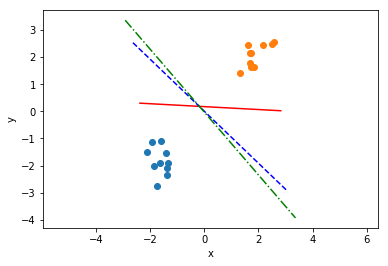

In [43]:
# SVM
def abline(slope, intercept, *fmt):
    '''
    Plot a line from slope and intercept
    adapted from https://stackoverflow.com/a/43811762/4557288
    :param slope: slope
    :param intercept: intercept
    :param *fmt: format arguments passed to pyplot.plot
    '''
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, *fmt)
    
    
plt.scatter(X[:N,0], X[:N,1])
plt.scatter(X[N:,0], X[N:,1])

# interior point
abline(-p0[0] / p0[1], p0[2] / p0[1], 'r')

# log-barrier solution
abline(-q_ast[0] / q_ast[1], q_ast[2] / q_ast[1], 'b--')

# primal-dual solution
abline(-q_pd[0] / q_pd[1], q_pd[2] / q_pd[1], 'g-.')

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()